In [ ]:
!pip install pandas
!pip install pandas pyreadstat
!pip install seaborn
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/FYP/fullsav.csv'

sav_data = pd.read_csv(data_path, low_memory=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#removes participants that does not have malaise
sav_data = sav_data.dropna(subset=['malaise'])

#removes sweep 0
all_sweeps = sav_data.iloc[:, 65:]


#variables chosen by bias (uncomment when want to use and comment the other)
'''
categorical_variable_names = [
    "n115", "n135", "n315", "n321", "n322", "n397", "n400", "n68", "n69", "n70", "n457",
    "n1444", "n1449", "n1687", "n1230", "n1476", "n862", "n876", "n877", "n878", "n879", "n1061",
    "n2441", "n2520", "n2529", "n2199", "n2285", "n2309", "n2314", "n2716", "n2719", "n2720",
    "n2721", "n2722", "n5739", "n5740", "n4655", "n4862", "n4659", "n4660", "n5613", "n6134",
    "n6147", "n4873", "n5066", "n5470", "econstat", "jobhours", "curremp"
]
'''
#variables chosen by chi-squared test (uncomment when want to use and comment the other)
categorical_variable_names = [
    'n70', 'n67', 'n68', 'n81', 'n69', 'n457', 'n43', 'n65', 'n44', 'n38', 'n390', 'n315',
    'n876', 'n877', 'n878', 'n879', 'n851', 'n958', 'n852', 'n1476', 'n862', 'n1136', 'n1152', 'n1061',
    'n2244', 'n2245', 'n2285', 'n2403', 'n2741', 'n2250', 'n2309', 'n2719', 'n2407', 'n2408', 'n2441', 'n2716',
    'n5739', 'econstat', 'n4662', 'n5740', 'n4655', 'jobhours', 'n4862', 'curremp', 'n4659', 'n4660', 'n5613'
]



numerical_variable_names = [
    "n383", "n90", "n1840", "n92", "dvht07", "dvrwt07", "dvwt07",
    "n1543", "n874", "n914", "n917", "n920", "n923", "n926", "n929",
    "dvht11", "dvrwt11", "dvwt11", "n1945", "n1701", "n1702", "n1703", "n1722",
    "n1760", "n2928", "n2930", "dvht16", "dvrwt16", "dvwt16", "n4331", "jobtime",
    "unemtime", "savinv", "earngsn", "famnet", "equiv", "feqn",
    "dvht23", "dvrwt23", "dvwt23"
]

auxilary_variable_names = [
    "n123", "n124", "n125", "n126", "n127",
    "n128", "n129", "n130", "n131", "n246", "n247", "n248", "n249", "n250", "n251",
    "n252", "n253", "n254", "n264", "n265", "n266", "n222",
    "n180", "n1434", "n204", "n205", "n206", "n207",
    "n208", "n209", "n2492", "n2825", "n2826", "n2827", "n2828", "n2829", "n2830", "n2831",
    "n2832", "n2833", "n2834", "n2835", "n2836", "n2837", "n2838", "n2839", "n2840", "n2841",
    "n2842", "n2843", "n2844", "n2845", "n2846", "n2847", "n2848", "n2849", "n2850", "n2851",
    "n2852", "n2853", "n2854", "n2855", "n2856", "n2857", "n2858", "n2859", "n2860", "n2861",
    "n2862", "n2863"
]

categorical_variables = all_sweeps[categorical_variable_names]

numerical_variables = all_sweeps[numerical_variable_names]

auxilary_variables = all_sweeps[auxilary_variable_names]

In [ ]:
#there is one numerical variable with a few text values. so this line of code removes those text values and sets the column as numeric
numerical_variables['n4331'] = pd.to_numeric(numerical_variables['n4331'], errors='coerce')

<ipython-input-3-f350244d87e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_variables['n4331'] = pd.to_numeric(numerical_variables['n4331'], errors='coerce')


In [ ]:
#first concatinates the chosen categorcial variables with numerical ones. Then adds the malaise outcome to be used as output label.
chosen_variables= pd.concat([categorical_variables, numerical_variables], axis=1)
chosen_variables = pd.concat([chosen_variables, sav_data[['malaise']]], axis=1)

In [ ]:
#applies lable encoder to malaise column
le = LabelEncoder()
chosen_variables['malaise'] = le.fit_transform(chosen_variables['malaise'])
chosen_variables['malaise'] = 1 - chosen_variables['malaise']

In [ ]:
#calculates the percentage of missing values for each column and removes those which have more than 32%
#it is mainly used for auxilary_variables since all selected variables were selected before using this
def clean_missing_data(df, missing_threshold=32):
  missing_percentage = df.isnull().mean() * 100
  columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index
  df_cleaned = df.drop(columns=columns_to_drop)
  return df_cleaned

#clean the variables one last time(if required)
chosen_variables_cleaned = clean_missing_data(chosen_variables)
auxilary_variables_cleaned = clean_missing_data(auxilary_variables, missing_threshold=25)

In [ ]:
#seperates the input data and output label
X = chosen_variables_cleaned.iloc[:, :-1]
Y = chosen_variables_cleaned.iloc[:, -1]

#seperates the data into numeric and categorical columns before OneHotEncoding
categorical_columns = [col for col in X.columns if X[col].dtype == "object"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

In [ ]:
#applies OneHotEncoding to auxilary variables and stores the names of the auxilary

auxilary_variables_columns = [col for col in auxilary_variables_cleaned.columns if auxilary_variables_cleaned[col].dtype == "object"]

ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), auxilary_variables_columns)], remainder='passthrough')

auxilary_transformed = ct2.fit_transform(auxilary_variables_cleaned)

new_auxilary_features = ct2.named_transformers_['encoder'].get_feature_names_out()

new_auxilary_column_names = list(new_auxilary_features)

auxilary_transformed_df = pd.DataFrame(auxilary_transformed, columns=new_auxilary_column_names)

display(auxilary_transformed_df)


In [ ]:
#applies OneHotEncoding to the categorical columns and creates new columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)], remainder='passthrough')

X_transformed = ct.fit_transform(X)

new_categorical_features = ct.named_transformers_['encoder'].get_feature_names_out(categorical_columns)

new_column_names = list(new_categorical_features) + numerical_columns

X_transformed_df = pd.DataFrame(X_transformed, columns=new_column_names)

In [ ]:
#concatinates the new categorical columns and auxilary variables.
X_transformed_df = pd.concat([X_transformed_df, auxilary_transformed_df], axis=1)

In [ ]:
#makes a copy of original indicies to later calculate the false positives and negatives' distance to malaise(being identified as depressed) threshold
X_transformed_df['original_index'] = sav_data.index
original_indices = X_transformed_df['original_index'].copy()

#first splits the X data into 60% training data 40% temp data. later splits the temp data 20% validation and 20% test data
X_train, X_temp, Y_train, Y_temp = train_test_split(X_transformed_df, Y, test_size=0.4, random_state=31)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=31)

train_original_indices = X_train['original_index'].copy()
val_original_indices = X_val['original_index'].copy()
test_original_indices = X_test['original_index'].copy()
original_indices = X_transformed_df['original_index'].copy()

X_transformed_df = X_transformed_df.drop(columns=['original_index'])
X_train = X_train.drop(columns=['original_index'])
X_val = X_val.drop(columns=['original_index'])
X_test = X_test.drop(columns=['original_index'])


In [ ]:
iterative_imputer = IterativeImputer(random_state=31)
#applies multiple imputation to each dataset seperately to avoid data leakage
X_train_imputed = iterative_imputer.fit_transform(X_train)
X_test_imputed = iterative_imputer.transform(X_test)
X_val_imputed = iterative_imputer.transform(X_val)

#adds the column names back
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=X_test.columns)
X_val_imputed_df = pd.DataFrame(X_val_imputed, columns=X_val.columns)

#removes the column names that are equal of auxilary variables. uncomment when want to use them
X_train_imputed_df = X_train_imputed_df.drop(columns=new_auxilary_column_names)
X_test_imputed_df = X_test_imputed_df.drop(columns=new_auxilary_column_names)
X_val_imputed_df = X_val_imputed_df.drop(columns=new_auxilary_column_names)

In [ ]:
min_max_scaler = MinMaxScaler()

min_max_scaler.fit(X_train_imputed_df[numerical_columns])

#applies normalisation to each numerical column in all datasets seperately to avoid data leakage

X_train_imputed_df[numerical_columns] = min_max_scaler.transform(X_train_imputed_df[numerical_columns])
X_test_imputed_df[numerical_columns] = min_max_scaler.transform(X_test_imputed_df[numerical_columns])
X_val_imputed_df[numerical_columns] = min_max_scaler.transform(X_val_imputed_df[numerical_columns])

In [ ]:
#applies SMOTE to data for class imbalance
smote = SMOTE(sampling_strategy=0.45, random_state=31)
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train_imputed_df, Y_train)

In [ ]:
#applies SMOTEENN to data for class imbalance
smote = SMOTE(sampling_strategy=0.45)
enn = EditedNearestNeighbours(sampling_strategy='all')

smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=31)
X_train_oversampled, Y_train_oversampled = smote_enn.fit_resample(X_train_imputed_df, Y_train)

In [ ]:
#applies Support Vector Machine Classifier model to the dataset and calculates the
#performance with multiple measurment methods such as confusion matrices
svm = SVC(C=0.005, kernel='linear', random_state=31)

svm.fit(X_train_oversampled, Y_train_oversampled)

svm_val_predictions = svm.predict(X_val_imputed_df)
svm_test_predictions = svm.predict(X_test_imputed_df)

svm_val_accuracy = accuracy_score(Y_val, svm_val_predictions)
svm_test_accuracy = accuracy_score(Y_test, svm_test_predictions)

svm_val_conf_matrix = confusion_matrix(Y_val, svm_val_predictions)
svm_test_conf_matrix = confusion_matrix(Y_test, svm_test_predictions)

confusion_matrices = {
    "SVM Validation": svm_val_conf_matrix,
    "SVM Test": svm_test_conf_matrix
}

for name, cm in confusion_matrices.items():
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  Sensitivity = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  Precision = TP / (TP + FP)
  F1_Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)
  print(f"\n{name}:")
  print("True Positives:", TP)
  print("True Negatives:", TN)
  print("False Positives:", FP)
  print("False Negatives:", FN)
  print("Sensitivity (Recall):", Sensitivity)
  print("Specificity:", Specificity)
  print("Precision:", Precision)
  print("F1 Score:", F1_Score)


svm_train_predictions_oversampled = svm.predict(X_train_oversampled)
svm_train_accuracy_oversampled = accuracy_score(Y_train_oversampled, svm_train_predictions_oversampled)

svm_train_predictions_original = svm.predict(X_train_imputed_df)
svm_train_accuracy_original = accuracy_score(Y_train, svm_train_predictions_original)

print("\nTraining Data Accuracy on Oversampled Set:")
print(f"SVM: {svm_train_accuracy_oversampled * 100:.2f}%")
print("\nTraining Data Accuracy on Original Set:")
print(f"SVM: {svm_train_accuracy_original * 100:.2f}%")

print("\nValidation Data Accuracy:")
print(f"SVM: {svm_val_accuracy * 100:.2f}%")

print("\nTest Data Accuracy:")
print(f"SVM: {svm_test_accuracy * 100:.2f}%")


SVM Validation:
True Positives: 97
True Negatives: 2137
False Positives: 176
False Negatives: 86
Sensitivity (Recall): 53.00546448087432
Specificity: 92.39083441418072
Precision: 35.53113553113553
F1 Score: 42.54385964912281

SVM Test:
True Positives: 81
True Negatives: 2156
False Positives: 160
False Negatives: 99
Sensitivity (Recall): 45.0
Specificity: 93.09153713298791
Precision: 33.60995850622407
F1 Score: 38.47980997624703

Training Data Accuracy on Oversampled Set:
SVM: 77.86%

Training Data Accuracy on Original Set:
SVM: 88.82%

Validation Data Accuracy:
SVM: 89.50%

Test Data Accuracy:
SVM: 89.62%


In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

#applies Naive Bayes models to the dataset and calculates the
#performance with multiple measurment methods such as confusion matrices

nb = BernoulliNB()

nb.fit(X_train_oversampled, Y_train_oversampled)

nb_val_predictions = nb.predict(X_val_imputed_df)
nb_test_predictions = nb.predict(X_test_imputed_df)

nb_val_accuracy = accuracy_score(Y_val, nb_val_predictions)
nb_test_accuracy = accuracy_score(Y_test, nb_test_predictions)

nb_val_conf_matrix = confusion_matrix(Y_val, nb_val_predictions)
nb_test_conf_matrix = confusion_matrix(Y_test, nb_test_predictions)

confusion_matrices = {
    "Naive Bayes Validation": nb_val_conf_matrix,
    "Naive Bayes Test": nb_test_conf_matrix
}

for name, cm in confusion_matrices.items():
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  Sensitivity = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  Precision = TP / (TP + FP)
  F1_Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)
  print(f"\n{name}:")
  print("True Positives:", TP)
  print("True Negatives:", TN)
  print("False Positives:", FP)
  print("False Negatives:", FN)
  print("Sensitivity (Recall):", Sensitivity)
  print("Specificity:", Specificity)
  print("Precision:", Precision)
  print("F1 Score:", F1_Score)

nb_train_predictions_oversampled = nb.predict(X_train_oversampled)
nb_train_accuracy_oversampled = accuracy_score(Y_train_oversampled, nb_train_predictions_oversampled)

nb_train_predictions_original = nb.predict(X_train_imputed_df)
nb_train_accuracy_original = accuracy_score(Y_train, nb_train_predictions_original)

print("\nTraining Data Accuracy on Oversampled Set:")
print(f"Naive Bayes: {nb_train_accuracy_oversampled * 100:.2f}%")
print("\nTraining Data Accuracy on Original Set:")
print(f"Naive Bayes: {nb_train_accuracy_original * 100:.2f}%")

print("\nValidation Data Accuracy:")
print(f"Naive Bayes: {nb_val_accuracy * 100:.2f}%")

print("\nTest Data Accuracy:")
print(f"Naive Bayes: {nb_test_accuracy * 100:.2f}%")

In [ ]:
from sklearn.linear_model import LogisticRegression

#applies Logistic Regression model to the dataset and calculates the
#performance with multiple measurment methods such as confusion matrices

log_reg = LogisticRegression(C=0.01, max_iter=1500, solver='saga', random_state=31)

log_reg.fit(X_train_oversampled, Y_train_oversampled)

log_reg_val_predictions = log_reg.predict(X_val_imputed_df)
log_reg_test_predictions = log_reg.predict(X_test_imputed_df)

log_reg_val_accuracy = accuracy_score(Y_val, log_reg_val_predictions)
log_reg_test_accuracy = accuracy_score(Y_test, log_reg_test_predictions)

log_reg_val_conf_matrix = confusion_matrix(Y_val, log_reg_val_predictions)
log_reg_test_conf_matrix = confusion_matrix(Y_test, log_reg_test_predictions)

confusion_matrices = {
    "Logistic Regression Validation": log_reg_val_conf_matrix,
    "Logistic Regression Test": log_reg_test_conf_matrix
}

for name, cm in confusion_matrices.items():
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  Sensitivity = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  Precision = TP / (TP + FP)
  F1_Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)
  print(f"\n{name}:")
  print("True Positives:", TP)
  print("True Negatives:", TN)
  print("False Positives:", FP)
  print("False Negatives:", FN)
  print("Sensitivity (Recall):", Sensitivity)
  print("Specificity:", Specificity)
  print("Precision:", Precision)
  print("F1 Score:", F1_Score)

log_reg_train_predictions_oversampled = log_reg.predict(X_train_oversampled)
log_reg_train_accuracy_oversampled = accuracy_score(Y_train_oversampled, log_reg_train_predictions_oversampled)

log_reg_train_predictions_original = log_reg.predict(X_train_imputed_df)
log_reg_train_accuracy_original = accuracy_score(Y_train, log_reg_train_predictions_original)

print("\nTraining Data Accuracy on Oversampled Set:")
print(f"Logistic Regression: {log_reg_train_accuracy_oversampled * 100:.2f}%")
print("\nTraining Data Accuracy on Original Set:")
print(f"Logistic Regression: {log_reg_train_accuracy_original * 100:.2f}%")

print("\nValidation Data Accuracy:")
print(f"Logistic Regression: {log_reg_val_accuracy * 100:.2f}%")

print("\nTest Data Accuracy:")
print(f"Logistic Regression: {log_reg_test_accuracy * 100:.2f}%")

In [ ]:
#applies Random Forest Classifier model to the dataset and calculates the
#performance with multiple measurment methods such as confusion matrices

rfc = RandomForestClassifier(n_estimators=20, random_state=31)

rfc.fit(X_train_oversampled, Y_train_oversampled)

rf_val_predictions = rfc.predict(X_val_imputed_df)
rf_test_predictions = rfc.predict(X_test_imputed_df)

rf_val_accuracy = accuracy_score(Y_val, rf_val_predictions)
rf_test_accuracy = accuracy_score(Y_test, rf_test_predictions)

rf_val_conf_matrix = confusion_matrix(Y_val, rf_val_predictions)
rf_test_conf_matrix = confusion_matrix(Y_test, rf_test_predictions)

confusion_matrices = {
    "Random Forest Validation": rf_val_conf_matrix,
    "Random Forest Test": rf_test_conf_matrix
}

for name, cm in confusion_matrices.items():
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  Sensitivity = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  Precision = TP / (TP + FP)
  F1_Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)
  print(f"\n{name}:")
  print("True Positives:", TP)
  print("True Negatives:", TN)
  print("False Positives:", FP)
  print("False Negatives:", FN)
  print("Sensitivity (Recall):", Sensitivity)
  print("Specificity:", Specificity)
  print("Precision:", Precision)
  print("F1 Score:", F1_Score)

rf_train_predictions_oversampled = rfc.predict(X_train_oversampled)
rf_train_accuracy_oversampled = accuracy_score(Y_train_oversampled, rf_train_predictions_oversampled)

rf_train_predictions_original = rfc.predict(X_train_imputed_df)
rf_train_accuracy_original = accuracy_score(Y_train, rf_train_predictions_original)

print("\nTraining Data Accuracy on Oversampled Set:")
print(f"Random Forest: {rf_train_accuracy_oversampled * 100:.2f}%")
print("\nTraining Data Accuracy on Original Set:")
print(f"Random Forest: {rf_train_accuracy_original * 100:.2f}%")

print("\nValidation Data Accuracy:")
print(f"Random Forest: {rf_val_accuracy * 100:.2f}%")

print("\nTest Data Accuracy:")
print(f"Random Forest: {rf_test_accuracy * 100:.2f}%")

<ipython-input-18-9ff024cbb614>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['0', '1'])
<ipython-input-18-9ff024cbb614>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['0', '1'])


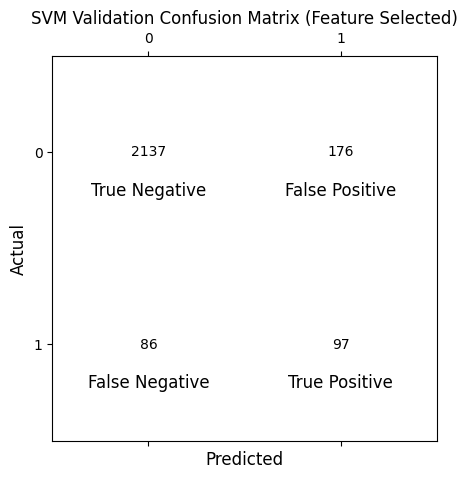

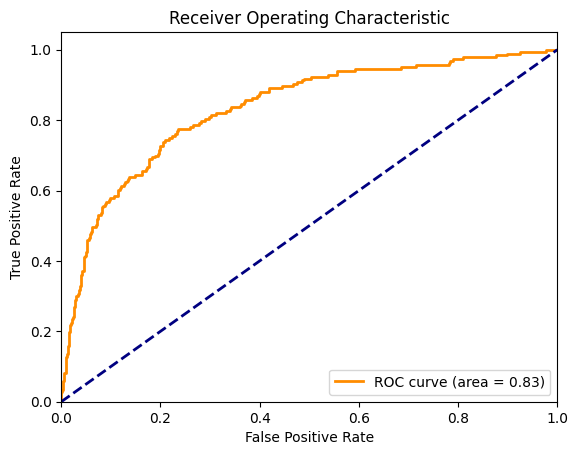

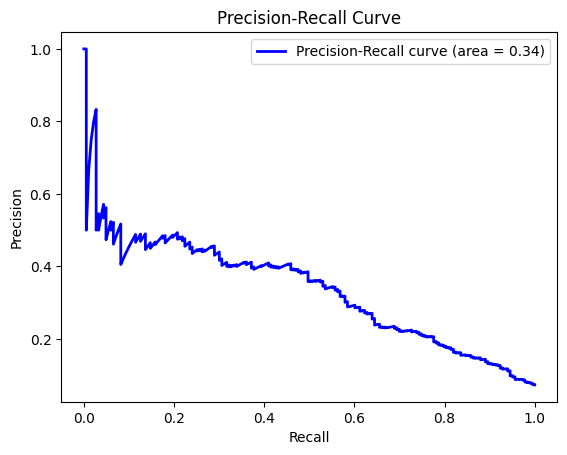

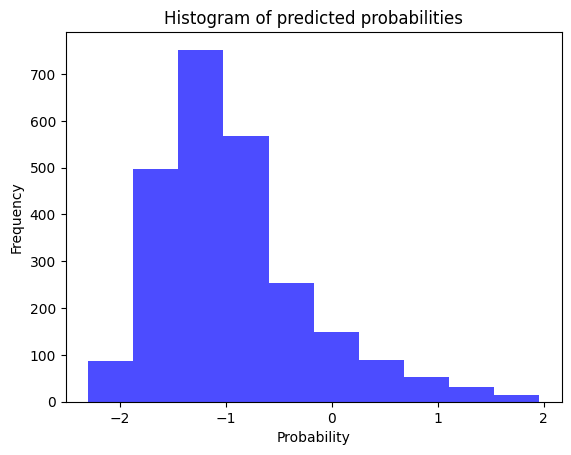

In [ ]:
#a function to plot the confusion matrix in seaborn
def plot_confusion_matrix(cm, title='Confusion Matrix'):
  fig, ax = plt.subplots(figsize=(6,5))
  cax = ax.matshow(cm, cmap='Greys', alpha=0)
  #adding the text labels
  for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    if i == j:
      if i == 0:
        ax.text(j, i+0.2, 'True Negative', ha='center', va='center', color='black', fontsize=12)
      else:
        ax.text(j, i+0.2, 'True Positive', ha='center', va='center', color='black', fontsize=12)
    else:
      if i == 0:
        ax.text(j, i+0.2, 'False Positive', ha='center', va='center', color='black', fontsize=12)
      else:
        ax.text(j, i+0.2, 'False Negative', ha='center', va='center', color='black', fontsize=12)
  ax.set_xticklabels(['']+['0', '1'])
  ax.set_yticklabels(['']+['0', '1'])
  plt.xlabel('Predicted', fontsize=12)
  plt.ylabel('Actual', fontsize=12)
  plt.title(title, fontsize=12)
  plt.show()

plot_confusion_matrix(svm_val_conf_matrix, 'SVM Validation Confusion Matrix (Feature Selected)')


#code to calculate Receiver Operating Characteristic(roc) of the selected model
svm_probabilities = svm.decision_function(X_val_imputed_df)
fpr, tpr, thresholds = roc_curve(Y_val, svm_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#code to calculate Precision-Recall Curve of the selected model

precision, recall, _ = precision_recall_curve(Y_val, svm_probabilities)
average_precision = average_precision_score(Y_val, svm_probabilities)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

#code to calculate Histogram of predicted probabilities of the selected model showing which
#class is more likely to be predicted, and the confidence of the model in its predictions.
plt.figure()
plt.hist(svm_probabilities, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


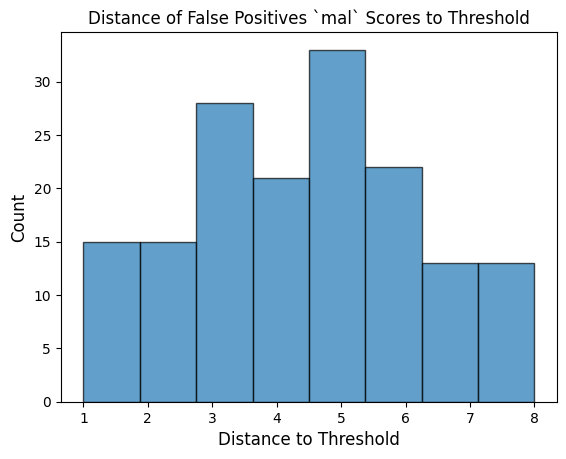

In [ ]:
#gets the correct identification of false positives
false_positives_indices = np.where((svm_test_predictions == 1) & (Y_test.values == 0))[0]

#uses the original_indices to locate the original rows in sav_data
original_indices_for_false_positives = test_original_indices.iloc[false_positives_indices].values

#extracts the malaise `mal` scores for these false positive cases
false_positives_mal_scores = sav_data.loc[original_indices_for_false_positives, 'mal']

# alculates the distance of false positive `mal` scores to the threshold which is 8
distance_to_threshold = abs(false_positives_mal_scores - 8)


#visualises the distribution of these distances as an histogram
plt.hist(distance_to_threshold, bins=8, edgecolor='k', alpha=0.7)
plt.title('Distance of False Positives `mal` Scores to Threshold', fontsize=12)
plt.xlabel('Distance to Threshold', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

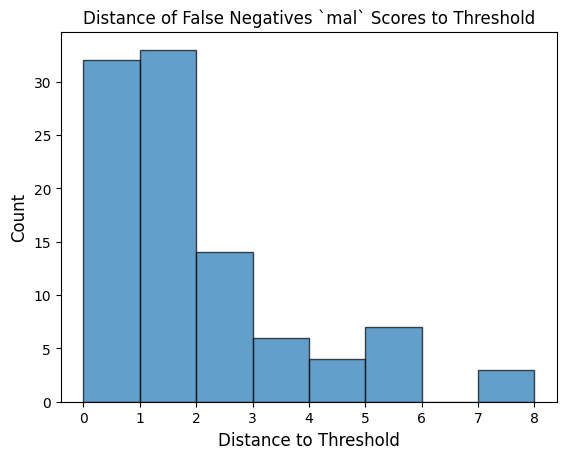

In [ ]:
#gets the correct identification of false negatives
false_negatives_indices = np.where((svm_test_predictions == 0) & (Y_test.values == 1))[0]

#uses the original_indices to locate the original rows in sav_data
original_indices_for_false_negatives = test_original_indices.iloc[false_negatives_indices].values

#extracts the malaise `mal` scores for these false negative cases
false_negatives_mal_scores = sav_data.loc[original_indices_for_false_negatives, 'mal']

# Analyzing the distance of false negative `mal` scores to the threshold which is 8
distance_to_threshold_fn = abs(false_negatives_mal_scores - 8)

#visualises the distribution of these distances as an histogram
plt.hist(distance_to_threshold_fn, bins=8, edgecolor='k', alpha=0.7)
plt.title('Distance of False Negatives `mal` Scores to Threshold', fontsize=12)
plt.xlabel('Distance to Threshold', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
